### Imports

In [22]:
using DSP
using WAV
using Plots
# using Polynomials

### Get test signal

In [23]:
function pre_emphasize(signal, alpha=0.95)
    filt_function = PolynomialRatio([1.0, -alpha], [1.0])
    return filt(filt_function, signal)
end

pre_emphasize (generic function with 2 methods)

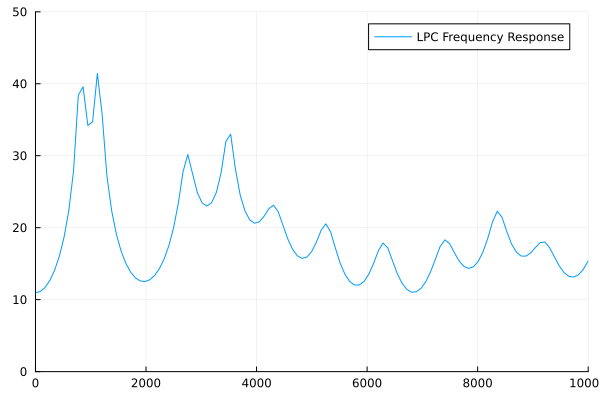

In [24]:
signal, fs, b, opt = wavread("demo_data/aa_audio/audio_lpc_aa_fo160.wav")
signal = signal[1:end]
signal1 = pre_emphasize(signal)
signal2 = pre_emphasize(signal1)
# signal3 = pre_emphasize(signal2)
order = 50
n = 256
a, e = lpc(signal2, order)
a = vcat(1.0, a)
filt_func = PolynomialRatio([1.0], a)
f = [0:(fs/2)/n:fs/2;]
resp = freqz(filt_func, f, fs)
resp = 20*log10.(abs.(resp))
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")

### Basic peak picking algorithm

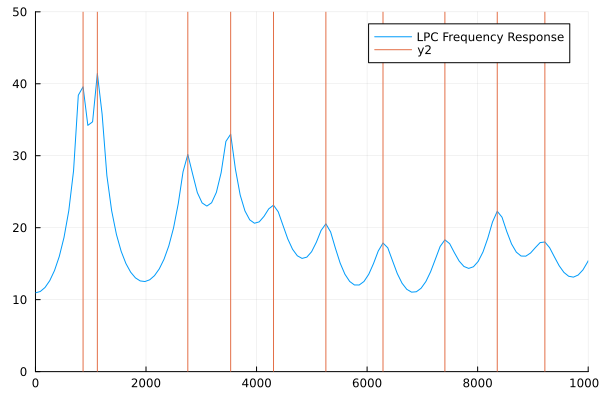

In [25]:
peaks = []
for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        push!(peaks, f[i])
    end
end
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
vline!(peaks)

### Peak picking algorithm with parabola fitting

In [26]:
# n_points = 5

# peaks = []
# parabolas = []

# for i in [2:1:length(resp)-1;]
#     prev = resp[i-1]
#     cur = resp[i]
#     next = resp[i+1]
#     if cur > prev && cur > next
#         # println(vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]))
#         quadfit = fit(vcat(f[i-n_points-1:i-1], f[i+1:i+1+n_points]), vcat(resp[i-n_points-1:i-1], resp[i+1:i+1+n_points]), 2)
#         push!(peaks, f[i])
#         push!(parabolas, quadfit)
#     end
# end

# plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
# scatter!(f, resp, markerstrokewidth=0, markersize=1)
# # vline!(peaks)
# plot!(parabolas[1], f[1], f[end], label="")
# plot!(parabolas[2], f[1], f[end], label="")
# plot!(parabolas[3], f[1], f[end], label="")
# plot!(parabolas[4], f[1], f[end], label="")

# # for parabola in parabolas
# #     plot!(parabola, f[1], f[end], label="")
# # end

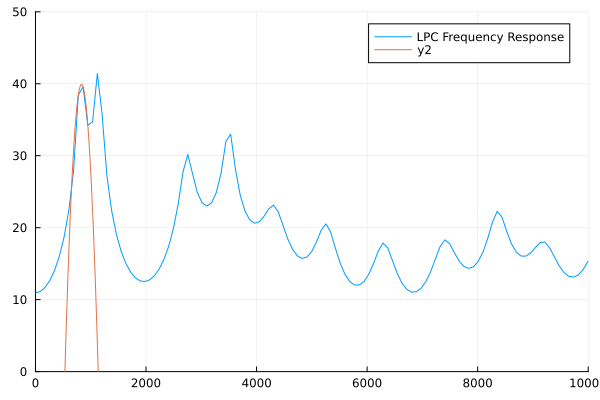

In [27]:
original_peaks = []
interpolated_peaks = []
parabolas = []

for i in [2:1:length(resp)-1;]
    prev = resp[i-1]
    cur = resp[i]
    next = resp[i+1]
    if cur > prev && cur > next
        println("found peak at $(f[i]), $(cur)")
        A = [(f[i-1])^2 (f[i-1]) 1; f[i]^2 f[i] 1; (f[i+1])^2 (f[i+1]) 1] 
        y = [prev; cur; next]
        coeffs = A \ y
        a, b, c = coeffs 
        parabola(x) = a * x^2 + b * x + c
        x_vals = [f[i-5]:10/500:f[i+5];]
        y_vals = parabola.(x_vals)
        push!(parabolas, (x_vals, y_vals))
    end
end
# println(parabolas[1][1], parabolas[1][2])
plot(f, resp, xlim=(0,10000), ylim=(0,50), label="LPC Frequency Response")
plot!(parabolas[1][1], parabolas[1][2])
# vline!(peaks)

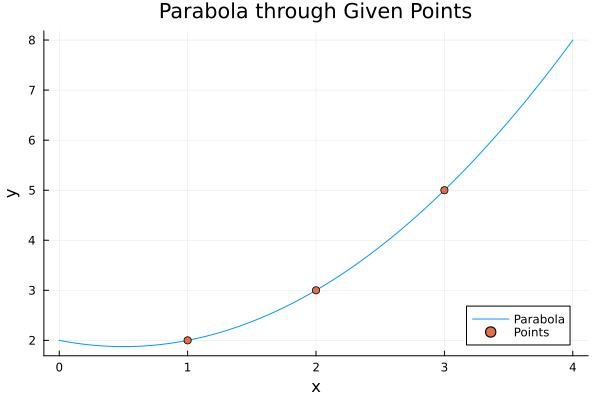

In [28]:
using LinearAlgebra
using Plots

# Function to compute the coefficients of the parabola
function find_parabola_coeffs(points)
    # Unpack the points
    (x1, y1), (x2, y2), (x3, y3) = points

    # Set up the system of equations
    A = [x1^2 x1 1; x2^2 x2 1; x3^2 x3 1]
    y = [y1; y2; y3]

    # Solve for the coefficients
    coeffs = A \ y

    return coeffs
end

# Function to plot the parabola
function plot_parabola(points)
    # Find the coefficients
    coeffs = find_parabola_coeffs(points)
    a, b, c = coeffs

    # Define the parabola function
    parabola(x) = a * x^2 + b * x + c

    # Generate x values for plotting
    x_vals = range(minimum([points[1][1], points[2][1], points[3][1]]) - 1, stop=maximum([points[1][1], points[2][1], points[3][1]]) + 1, length=500)
    y_vals = parabola.(x_vals)

    # Plot the parabola and the points
    plot(x_vals, y_vals, label="Parabola", xlabel="x", ylabel="y", title="Parabola through Given Points")
    scatter!([points[1][1], points[2][1], points[3][1]], [points[1][2], points[2][2], points[3][2]], label="Points", legend=:bottomright)
end

# Example points
points = [(1, 2), (2, 3), (3, 5)]

# Plot the parabola
plot_parabola(points)